# Program Deteksi Kelayuan Tanaman Hidroponik Sistem Vertikal

## Import Semua Pustaka yang Diperlukan

In [2]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.callbacks import EarlyStopping
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

## Atur Properti Gambar dan Pelatihan

In [3]:
# Parameter
img_height, img_width = 128, 128
batch_size = 32
epochs = 50

## Unduh Dataset

In [7]:
# Unduh CSV file
csv_file = 'dataset/_classes.csv'
data = pd.read_csv(csv_file)

In [8]:
# Direktori Gambar
image_directory = 'dataset/images/'

## Buat Dataframe

In [9]:
# Create a DataFrame with image file paths and labels
data['image_path'] = data['filename'].apply(lambda x: f'{image_directory}/{x}')

# Convert label values to strings
data['label'] = data['label'].apply(lambda x: 'wilt' if x == 1 else 'fresh')

## Bagi Menjadi Data Training dan Testing

In [10]:
# Split the dataset into training and testing sets
train_df, test_df = train_test_split(data, test_size=0.3, stratify=data['label'], random_state=42)

In [11]:
train_df

,filename,label,image_path
287,image_288.jpg,wilt,dataset/images//image_288.jpg
244,image_245.jpg,wilt,dataset/images//image_245.jpg
225,image_226.jpg,wilt,dataset/images//image_226.jpg
540,image_541.jpg,wilt,dataset/images//image_541.jpg
442,image_443.jpg,fresh,dataset/images//image_443.jpg
...,...,...,...
780,image_781.jpg,wilt,dataset/images//image_781.jpg
854,image_855.jpg,fresh,dataset/images//image_855.jpg
610,image_611.jpg,wilt,dataset/images//image_611.jpg
617,image_618.jpg,wilt,dataset/images//image_618.jpg


In [12]:
test_df

,filename,label,image_path
572,image_573.jpg,wilt,dataset/images//image_573.jpg
404,image_405.jpg,wilt,dataset/images//image_405.jpg
820,image_821.jpg,wilt,dataset/images//image_821.jpg
328,image_329.jpg,wilt,dataset/images//image_329.jpg
146,image_147.jpg,wilt,dataset/images//image_147.jpg
...,...,...,...
558,image_559.jpg,fresh,dataset/images//image_559.jpg
547,image_548.jpg,wilt,dataset/images//image_548.jpg
420,image_421.jpg,fresh,dataset/images//image_421.jpg
514,image_515.jpg,wilt,dataset/images//image_515.jpg


In [13]:
# Print label distribution
print("Label distribution in full dataset:")
print(data['label'].value_counts())

Label distribution in full dataset:
label
fresh    460
wilt     415
Name: count, dtype: int64


In [14]:
# Print label distribution in splits
print("\nLabel distribution in training set:")
print(train_df['label'].value_counts())

print("\nLabel distribution in test set:")
print(test_df['label'].value_counts())


Label distribution in training set:
label
fresh    322
wilt     290
Name: count, dtype: int64

Label distribution in test set:
label
fresh    138
wilt     125
Name: count, dtype: int64


## Buat Data Augmentasi

In [15]:
# Create ImageDataGenerators with data augmentation for training
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

In [16]:
test_datagen = ImageDataGenerator(rescale=1./255)

In [17]:
train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col='image_path',
    y_col='label',
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary'
)

Found 612 validated image filenames belonging to 2 classes.


In [18]:
test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_df,
    x_col='image_path',
    y_col='label',
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary',
    shuffle=False
)

Found 263 validated image filenames belonging to 2 classes.


In [19]:
# Check class labels
print("\nClasses in train generator:")
print(train_generator.class_indices)


Classes in train generator:
{'fresh': 0, 'wilt': 1}


# Buat Model Deep Learning

In [20]:
def createModel():
    model = Sequential([
        Conv2D(32, (4, 4), activation='relu', input_shape=(img_height, img_width, 3)),
        MaxPooling2D((3, 3)),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Conv2D(128, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(1, activation='sigmoid')  # For 2 labels
    ])
    return model    

In [21]:
model = createModel()

In [22]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [23]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 125, 125, 32)      1568      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 41, 41, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 39, 39, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 19, 19, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 17, 17, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 8, 8, 128)        0

## Train Data

In [25]:
# Early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

In [26]:
# Train the model
history = model.fit(
    train_generator,
    validation_data=test_generator,
    epochs=epochs,
    callbacks=[early_stopping]
)


Epoch 1/50
20/20 [==============================] - 9s 366ms/step - loss: 0.7200 - accuracy: 0.4820 - val_loss: 0.6782 - val_accuracy: 0.5247
Epoch 2/50
20/20 [==============================] - 7s 333ms/step - loss: 0.6735 - accuracy: 0.5899 - val_loss: 0.6035 - val_accuracy: 0.7452
Epoch 3/50
20/20 [==============================] - 7s 332ms/step - loss: 0.5625 - accuracy: 0.6928 - val_loss: 0.5507 - val_accuracy: 0.7148
Epoch 4/50
20/20 [==============================] - 7s 335ms/step - loss: 0.5288 - accuracy: 0.7304 - val_loss: 0.4852 - val_accuracy: 0.7605
Epoch 5/50
20/20 [==============================] - 7s 330ms/step - loss: 0.4882 - accuracy: 0.7778 - val_loss: 0.5041 - val_accuracy: 0.7605
Epoch 6/50
20/20 [==============================] - 8s 401ms/step - loss: 0.5890 - accuracy: 0.6814 - val_loss: 0.4862 - val_accuracy: 0.7681
Epoch 7/50
20/20 [==============================] - 7s 367ms/step - loss: 0.4897 - accuracy: 0.7614 - val_loss: 0.4609 - val_accuracy: 0.7795
Epoch 

## Plot Hasil Training

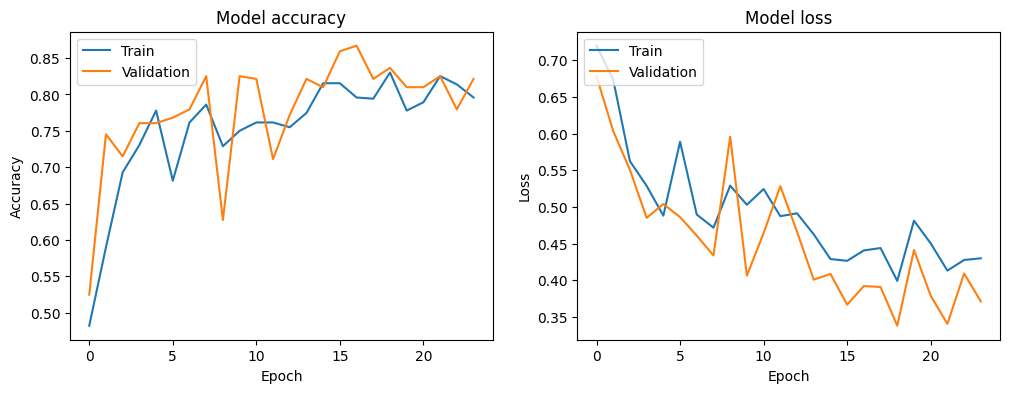

In [27]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.savefig("training.png", bbox_inches ="tight")

plt.show()

In [28]:
# Save the model
#model.save('crop_freshness_model.h5')

## Evaluasi Hasil

In [29]:
from sklearn.metrics import multilabel_confusion_matrix, classification_report, accuracy_score, precision_score, recall_score, f1_score

9/9 [==============================] - 1s 59ms/step

Confusion Matrix:
[[111  27]
 [ 16 109]]


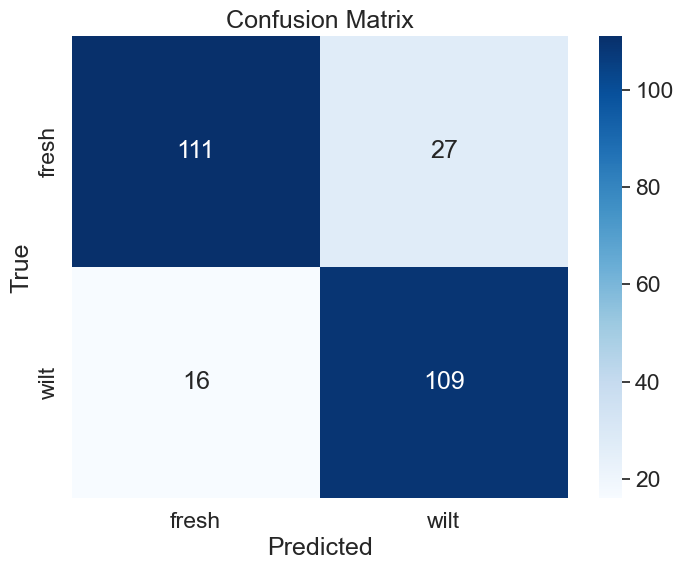


Classification Report:
              precision    recall  f1-score   support

       fresh       0.87      0.80      0.84       138
        wilt       0.80      0.87      0.84       125

    accuracy                           0.84       263
   macro avg       0.84      0.84      0.84       263
weighted avg       0.84      0.84      0.84       263



In [30]:
# Evaluate the model on the test set and get predictions
test_generator.reset()
predictions = model.predict(test_generator)
predicted_classes = (predictions > 0.5).astype("int32").flatten()

# Get true labels from the test generator
true_classes = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

# Compute confusion matrix
conf_matrix = confusion_matrix(true_classes, predicted_classes)
print("\nConfusion Matrix:")
print(conf_matrix)

# Display confusion matrix using seaborn heatmap
plt.figure(figsize=(8, 6))
sns.set(font_scale=1.5) 
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.savefig("Confusion Matrix.png", bbox_inches ="tight")

plt.show()

# Print classification report
print("\nClassification Report:")
print(classification_report(true_classes, predicted_classes, target_names=class_labels))

## Visualisasi Model Deep Learning

In [31]:
import visualkeras

In [32]:
from PIL import ImageFont

In [33]:
from tensorflow.keras import layers
from collections import defaultdict
color_map = defaultdict(dict)
color_map[layers.Conv2D]['fill'] = '#00f5d4'
color_map[layers.MaxPooling2D]['fill'] = '#8338ec'
color_map[layers.Dropout]['fill'] = '#03045e'
color_map[layers.Dense]['fill'] = '#fb5607'
color_map[layers.Flatten]['fill'] = '#ffbe0b'
font = ImageFont.truetype("arial.ttf", 16)

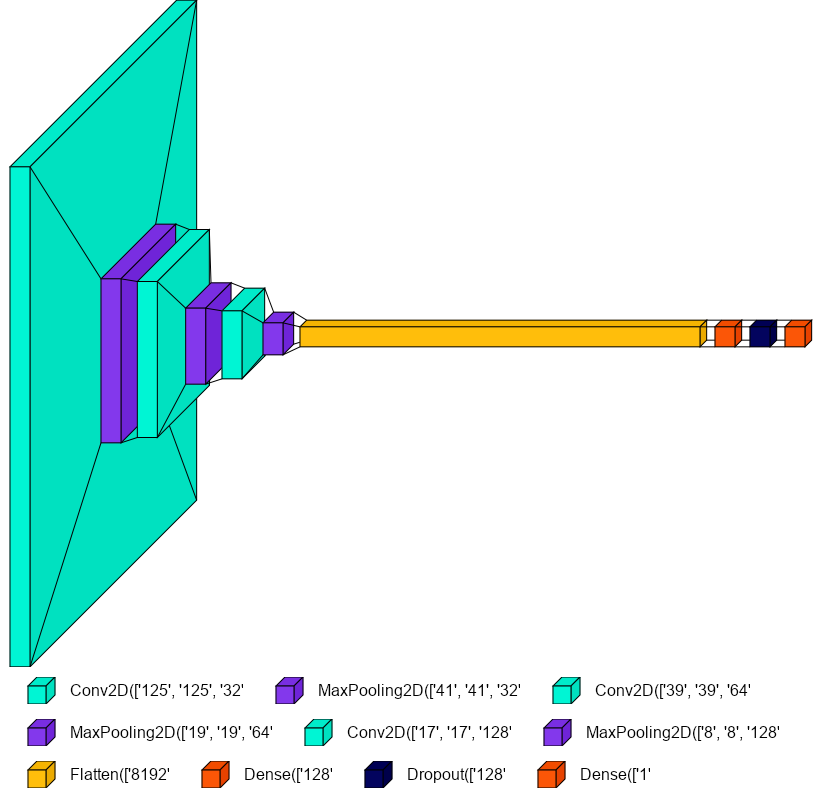

In [34]:
visualkeras.layered_view(model, legend=True,color_map=color_map, show_dimension=True, font=font, spacing=15, to_file='hidroponik.png')